## Association Rule Learning Homework

*Prepared by:*
**Jude Michael Teves**  
Faculty, Software Technology Department  
College of Computer Studies - De La Salle University

---

Submitted by:
- Guerra, Jose Maria Angelo
- Hinolan, Charles Joseph
- Lasala, Kyle Carlo
- Lorenzo, Antonio Jose Maria
- Roco, Katrina Bianca

## Requirements

Answer the following questions:

**Groceries Dataset**  
1. Calculate the association rules and find the `significant/interesting` items in this dataset. Feel free to use any threshold value. (10 pts)
    - group the items by member
    - group the items by month
2. What would you recommend to the owner of a grocery store given these association rules? (15 pts)
3. Is there any other grouping that could give us high confidence/interest? (10 pts)

**Another Dataset**  
1. Find another dataset that can be turned into an association rule learning problem. Ideally, more than 1000 transactions/records. This does not have to be grocery-related. (20 pts)
2. Similar to the grocery dataset, calculate the association rules and find the `significant/interesting` items. (10 pts)
3. What would you recommend given the association rules? (25 pts)
4. Any other learning?

Note:
 - You have to create a writeup on the code you've written. Make sure that the code is clean as well. (5 pts)
 - Cite references if there are any. If you will be using the code I've given, cite it. If you got help from your peers, cite it as well. (5 pts)
 - Submit the link for your copy of this Google Colaboratory notebook. **Make sure it's public**. You may use incognito to see if the link is accessible.

<hr>

## Grading Criteria

|Criteria|Points|
|---|---|
|Groceries Dataset Analysis|35|
|Another Dataset Analysis|55|
|Code Cleanliness|5|
|References|5|


# __Groceries Dataset__

## Preliminaries

### Import libraries

We will be using the `PyFIM` library to do association rule learning in this homework. If this is not already installed in your environment, you may use the either of the following commands in your command line:

```conda install -c conda-forge pyfim``` or
```pip install pyfim```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fim import arules, apriori, fpgrowth

### Prepare the dataset

We will be utilizing the <a href="https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset">Groceries dataset</a> from Kaggle.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Cyntwikip/data-repository/main/groceries.csv')
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


## Data Preprocessing

In [3]:
# checking datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [4]:
# convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


In [5]:
# checking items
unique_items = df['itemDescription'].unique()
print("Number of Unique Items:", len(unique_items))
print(sorted(unique_items))

Number of Unique Items: 167
['Instant food products', 'UHT-milk', 'abrasive cleaner', 'artif. sweetener', 'baby cosmetics', 'bags', 'baking powder', 'bathroom cleaner', 'beef', 'berries', 'beverages', 'bottled beer', 'bottled water', 'brandy', 'brown bread', 'butter', 'butter milk', 'cake bar', 'candles', 'candy', 'canned beer', 'canned fish', 'canned fruit', 'canned vegetables', 'cat food', 'cereals', 'chewing gum', 'chicken', 'chocolate', 'chocolate marshmallow', 'citrus fruit', 'cleaner', 'cling film/bags', 'cocoa drinks', 'coffee', 'condensed milk', 'cooking chocolate', 'cookware', 'cream', 'cream cheese ', 'curd', 'curd cheese', 'decalcifier', 'dental care', 'dessert', 'detergent', 'dish cleaner', 'dishes', 'dog food', 'domestic eggs', 'female sanitary products', 'finished products', 'fish', 'flour', 'flower (seeds)', 'flower soil/fertilizer', 'frankfurter', 'frozen chicken', 'frozen dessert', 'frozen fish', 'frozen fruits', 'frozen meals', 'frozen potato products', 'frozen vegeta

Grouped the items by `Member_number` and `Date`

In [6]:
df_grouped = df.groupby(['Member_number','Date']).agg(list)
df_grouped.sort_values(['Member_number', 'Date'], inplace=True)
df_grouped

itemDescription
Member_number Date                                                         
1000          2014-06-24                  [whole milk, pastry, salty snack]
              2015-03-15  [sausage, whole milk, semi-finished bread, yog...
              2015-05-27                         [soda, pickled vegetables]
              2015-07-24                     [canned beer, misc. beverages]
              2015-11-25                        [sausage, hygiene articles]
...                                                                     ...
4999          2015-05-16                  [butter milk, whipped/sour cream]
              2015-12-26                             [bottled water, herbs]
5000          2014-03-09                    [fruit/vegetable juice, onions]
              2014-11-16                   [bottled beer, other vegetables]
              2015-02-10       [soda, root vegetables, semi-finished bread]

[14963 rows x 1 columns]

In [7]:
# convert to list format
transactions = df_grouped['itemDescription'].to_list()
transactions

[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['frankfurter', 'soda', 'whipped/sour cream'],
 ['beef', 'white bread'],
 ['frankfurter', 'curd'],
 ['frozen vegetables', 'other vegetables'],
 ['butter', 'whole milk'],
 ['tropical fruit', 'sugar'],
 ['butter milk', 'specialty chocolate'],
 ['frozen meals', 'dental care'],
 ['rolls/buns', 'rolls/buns'],
 ['root vegetables', 'detergent'],
 ['sausage', 'rolls/buns'],
 ['pip fruit', 'whole milk', 'tropical fruit'],
 ['dish cleaner', 'cling film/bags'],
 ['rolls/buns', 'red/blush wine', 'chocolate'],
 ['canned beer', 'frozen fish'],
 ['other vegetables', 'shopping bags'],
 ['root vegetables', 'whole milk', 'pastry'],
 ['whole milk', 'chocolate', 'packaged fruit/vegetables', 'rolls/buns'],
 ['other vegetables', 'hygiene

## Association Rule Learning

### Frequent Itemset Mining

In [8]:
# calculates the frequent itemset using fpgrowth algorithm
def get_fim(supp, transactions):
    result = fpgrowth(transactions, supp=supp, report='as')
    colnames = ['itemset'] + ['support_absolute', 'support_relative']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

Checking for ideal support threshold

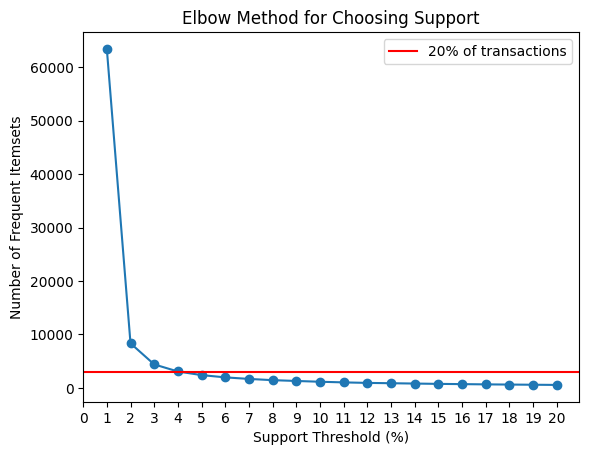

In [9]:
supports = range(1, 21)  # Test supports from 1% to 20%
num_itemsets = []

for supp in supports:
    rules = get_fim(supp*-1, transactions)
    num_itemsets.append(len(rules))

plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_grouped)*0.2, color = 'r', label = '20% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

Zoom in the Plot

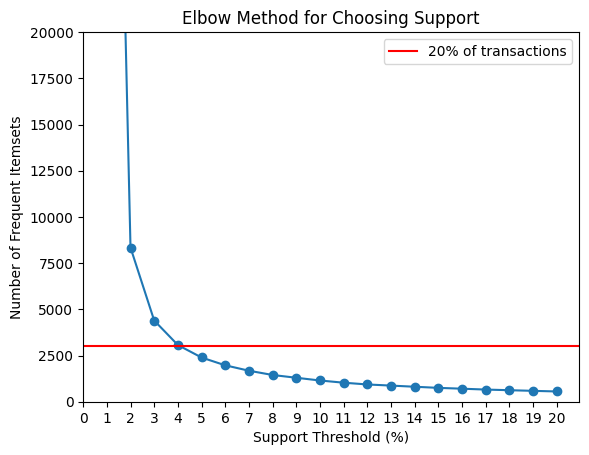

In [10]:
plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_grouped)*0.2, color = 'r', label = '20% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.ylim([0,20000])
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

Support Threshold is obtained through the **elbow method** (inspired from KMeans Clustering) to generate *enough* rules and avoid *noise*. <br/>
Ideally we want to be approximately equal to 20% of the transactions (represented by the redline) and not very steep nor flat at the given point so that we avoid the exteremely rare and extremely common itemsets. <br/>
***Support Threshold is set to 4.***

Get the Frequent Itemsets given that Support Threshold is set to 4

In [11]:
get_fim(-4, transactions)

,itemset,support_absolute,support_relative
0,"(whole milk,)",2363,0.157923
2,"(other vegetables,)",1827,0.122101
6,"(rolls/buns,)",1646,0.110005
13,"(soda,)",1453,0.097106
24,"(yogurt,)",1285,0.085879
...,...,...,...
1635,"(meat, waffles)",4,0.000267
250,"(shopping bags, pip fruit, rolls/buns)",4,0.000267
602,"(butter, pastry, other vegetables)",4,0.000267
1280,"(salty snack, yogurt, whole milk)",4,0.000267


### Significant Itemsets

In [12]:
# calculates the frequent itemset using fpgrowth algorithm
def get_sig(supp, conf, transactions):

    result = arules(transactions, supp=supp, conf=conf, report='asc')
    colnames = ['consequent', 'antecedent'] + ['support_absolute', 'support_relative', 'confidence_pct']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

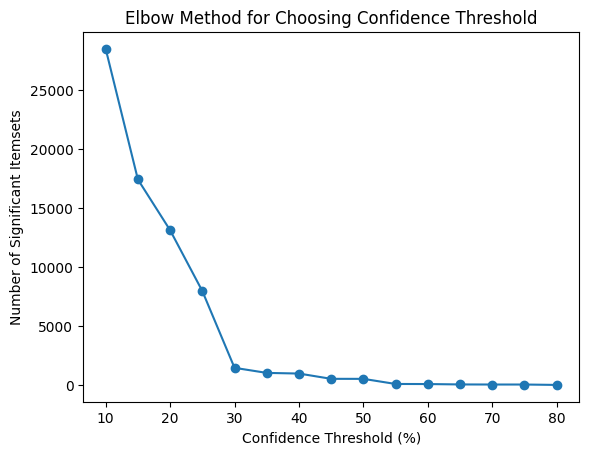

In [13]:
confidence = range(10, 81, 5)  # Test supports from 1% to 20%
num_itemsets = []

for conf in confidence:
    rules = get_sig(-4, conf, transactions)
    num_itemsets.append(len(rules))

plt.plot(confidence, num_itemsets, marker='o')
plt.xlabel("Confidence Threshold (%)")
plt.ylabel("Number of Significant Itemsets")
plt.title("Elbow Method for Choosing Confidence Threshold")
plt.show()

In [14]:
get_sig(-4, 30, transactions)

,consequent,antecedent,support_absolute,support_relative,confidence_pct
1418,whole milk,"(brandy,)",13,0.000869,0.342105
230,whole milk,"(pork, sausage)",9,0.000601,0.391304
348,whole milk,"(beef, whipped/sour cream)",7,0.000468,0.333333
249,other vegetables,"(pork, citrus fruit)",7,0.000468,0.350000
601,whole milk,"(sugar, other vegetables)",7,0.000468,0.368421
...,...,...,...,...,...
562,rolls/buns,"(onions, UHT-milk)",2,0.000134,0.400000
561,whole milk,"(onions, UHT-milk)",2,0.000134,0.400000
559,bottled water,"(onions, margarine)",2,0.000134,0.500000
558,onions,"(margarine, bottled water, other vegetables)",2,0.000134,0.400000


**Groceries Dataset**  
1. Calculate the association rules and find the `significant/interesting` items in this dataset. Feel free to use any threshold value. (10 pts)
    - group the items by member
    - group the items by month
2. What would you recommend to the owner of a grocery store given these association rules? (15 pts)
    - The owner of the grocery store can use the association rules to determine which items are frequently bought together. In this case, we recommend that the store place the following items near each other to encourage customers to buy them together (top 3):
        - whole milk and brandy
        - whole milk and meat (pork/sausage)
        - whole milk with whipped/sour cream and beef

3. Is there any other grouping that could give us high confidence/interest? (10 pts)
    - Another grouping that could give us high confidence/interest is grouping the items by day. This will allow the store to determine which items are frequently bought together on a daily basis.

## Grocery Dataset Association Rule by Day

In [15]:
#Create day column
df['Day'] = df['Date'].dt.day_name()
df


,Member_number,Date,itemDescription,Day
0,1808,2015-07-21,tropical fruit,Tuesday
1,2552,2015-01-05,whole milk,Monday
2,2300,2015-09-19,pip fruit,Saturday
3,1187,2015-12-12,other vegetables,Saturday
4,3037,2015-02-01,whole milk,Sunday
...,...,...,...,...
38760,4471,2014-10-08,sliced cheese,Wednesday
38761,2022,2014-02-23,candy,Sunday
38762,1097,2014-04-16,cake bar,Wednesday
38763,1510,2014-12-03,fruit/vegetable juice,Wednesday


In [16]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
 3   Day              38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.2+ MB


In [17]:
df_grouped = df.groupby(['Member_number','Day']).agg(list)
df_grouped.sort_values(['Member_number', 'Day'], inplace=True)
df_grouped

Date  \
Member_number Day                                                            
1000          Friday            [2015-07-24 00:00:00, 2015-07-24 00:00:00]   
              Sunday     [2015-03-15 00:00:00, 2015-03-15 00:00:00, 201...   
              Tuesday    [2014-06-24 00:00:00, 2014-06-24 00:00:00, 201...   
              Wednesday  [2015-05-27 00:00:00, 2015-11-25 00:00:00, 201...   
1001          Friday     [2014-02-07 00:00:00, 2014-12-12 00:00:00, 201...   
...                                                                    ...   
4999          Monday            [2014-05-19 00:00:00, 2014-05-19 00:00:00]   
              Saturday   [2015-12-26 00:00:00, 2015-05-16 00:00:00, 201...   
              Wednesday  [2015-02-18 00:00:00, 2014-04-09 00:00:00, 201...   
5000          Sunday     [2014-11-16 00:00:00, 2014-03-09 00:00:00, 201...   
              Tuesday    [2015-02-10 00:00:00, 2015-02-10 00:00:00, 201...   

                                                           itemDescription  
Member_number Day                                                           
1000          Friday                        [canned beer, misc. beverages]  
              Sunday     [sausage, whole milk, semi-finished bread, yog...  
              Tuesday                    [whole milk, pastry, salty snack]  
              Wednesday  [soda, sausage, pickled vegetables, hygiene ar...  
1001          Friday     [sausage, whole milk, whole milk, soda, rolls/...  
...                                                                    ...  
4999          Monday                         [other vegetables, detergent]  
              Saturday   [bottled water, butter milk, tropical fruit, b...  
              Wednesday  [berries, semi-finished bread, onions, newspap...  
5000          Sunday     [bottled beer, fruit/vegetable juice, other ve...  
              Tuesday         [soda, root vegetables, semi-finished bread]  

[11560 rows x 2 columns]

In [18]:
transactions = df_grouped['itemDescription'].to_list()
transactions

[['canned beer', 'misc. beverages'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['whole milk', 'pastry', 'salty snack'],
 ['soda', 'sausage', 'pickled vegetables', 'hygiene articles'],
 ['sausage', 'whole milk', 'whole milk', 'soda', 'rolls/buns'],
 ['frankfurter', 'curd'],
 ['frankfurter', 'beef', 'soda', 'white bread', 'whipped/sour cream'],
 ['butter', 'whole milk'],
 ['tropical fruit',
  'butter milk',
  'frozen vegetables',
  'sugar',
  'specialty chocolate',
  'other vegetables'],
 ['frozen meals', 'dental care'],
 ['rolls/buns', 'rolls/buns'],
 ['sausage', 'rolls/buns'],
 ['root vegetables', 'detergent'],
 ['whole milk', 'chocolate', 'packaged fruit/vegetables', 'rolls/buns'],
 ['other vegetables', 'shopping bags', 'dish cleaner', 'cling film/bags'],
 ['pip fruit',
  'root vegetables',
  'canned beer',
  'rolls/buns',
  'whole milk',
  'whole milk',
  'frozen fish',
  'red/blush wine',
  'tropical fruit',
  'chocolate',
  'pastry'],
 ['other vegetables', 'hygi

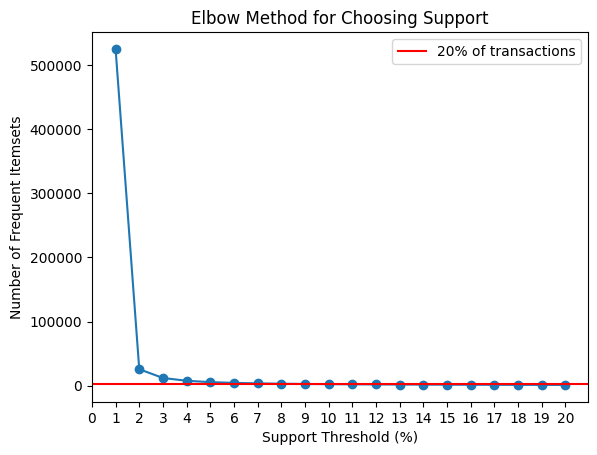

In [19]:
supports = range(1, 21)  # Test supports from 1% to 20%
num_itemsets = []

for supp in supports:
    rules = get_fim(supp*-1, transactions)
    num_itemsets.append(len(rules))

plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_grouped)*0.2, color = 'r', label = '20% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

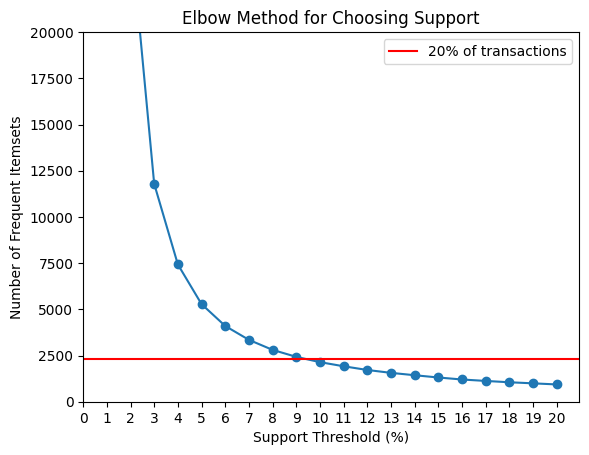

In [20]:
plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_grouped)*0.2, color = 'r', label = '20% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.ylim([0,20000])
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

In [21]:
get_fim(-9, transactions)

,itemset,support_absolute,support_relative
0,"(whole milk,)",2253,0.194896
2,"(other vegetables,)",1771,0.153201
6,"(rolls/buns,)",1595,0.137976
13,"(soda,)",1411,0.122059
25,"(yogurt,)",1258,0.108824
...,...,...,...
1970,"(soft cheese, whipped/sour cream)",9,0.000779
1966,"(soft cheese, citrus fruit)",9,0.000779
1964,"(soft cheese, tropical fruit)",9,0.000779
1961,"(soft cheese, yogurt, other vegetables)",9,0.000779


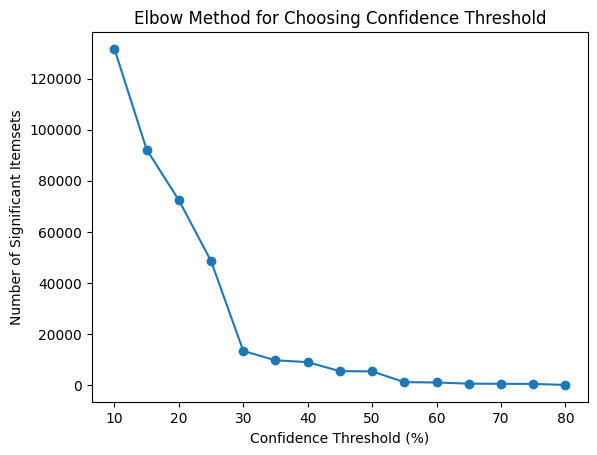

In [22]:
confidence = range(10, 81, 5)  # Test supports from 1% to 20%
num_itemsets = []

for conf in confidence:
    rules = get_sig(-4, conf, transactions)
    num_itemsets.append(len(rules))

plt.plot(confidence, num_itemsets, marker='o')
plt.xlabel("Confidence Threshold (%)")
plt.ylabel("Number of Significant Itemsets")
plt.title("Elbow Method for Choosing Confidence Threshold")
plt.show()

In [23]:
get_sig(-9, 30, transactions)

,consequent,antecedent,support_absolute,support_relative,confidence_pct
24,whole milk,"(sausage, yogurt)",42,0.003633,0.344262
59,whole milk,"(pastry, rolls/buns)",33,0.002855,0.343750
58,whole milk,"(pastry, other vegetables)",31,0.002682,0.310000
65,whole milk,"(pastry, yogurt)",27,0.002336,0.333333
120,whole milk,"(pip fruit, yogurt)",26,0.002249,0.333333
...,...,...,...,...,...
1116,other vegetables,"(butter milk, soda, whole milk)",3,0.000260,0.300000
1117,rolls/buns,"(butter milk, soda, whole milk)",3,0.000260,0.300000
1118,soda,"(butter milk, rolls/buns, whole milk)",3,0.000260,0.300000
1120,rolls/buns,"(butter milk, yogurt, whole milk)",3,0.000260,0.300000


# Spotify Dataset

## Preliminaries

In [24]:
#path = r"C:\Users\bianc\Desktop\AssocRuleLearning\dataset.csv"
path = r"dataset.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [25]:
df.dtypes

,0
track_id,object
artists,object
album_name,object
track_name,object
popularity,int64
duration_ms,int64
explicit,bool
danceability,float64
energy,float64
key,int64


## Data Preprocessing

### Dropping Null Values

In [26]:
df.isnull().sum()

,0
track_id,0
artists,1
album_name,1
track_name,1
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0
key,0


In [27]:
df = df.dropna()

### Removing Duplicates

In [28]:
print(df['track_id'].duplicated().sum())

24259


In [29]:
df['track_id'].value_counts().head(10)


,count
track_id,
6S3JlDAGk3uu3NtZbPnuhS,9
2Ey6v4Sekh3Z0RUSISRosD,8
2kkvB3RNRzwjFdGhaUA0tz,8
08kTa3SL9sV6Iy8KLKtGql,7
4XYieGKSlJlHpzB3bl6WMP,7
5ZsAhuQ24mWHiduaxJqnhW,7
0YLSjVxSb5FT1Bo8Tnxr8j,7
4WJTKbNJQ41zXnb84jSWaj,7
2aaClnypAakdAmLw74JXxB,7


retain the most popular version of each song

In [30]:
df = df.sort_values(by='popularity', ascending=False).drop_duplicates(subset='track_id').reset_index(drop=True)
print(df['track_id'].duplicated().sum())

0


### Preprocessing Int Columns

In [83]:
int_cols = df.select_dtypes(include=['int64']).columns
int_cols

Index(['popularity', 'duration_ms', 'key', 'mode', 'time_signature'], dtype='object')

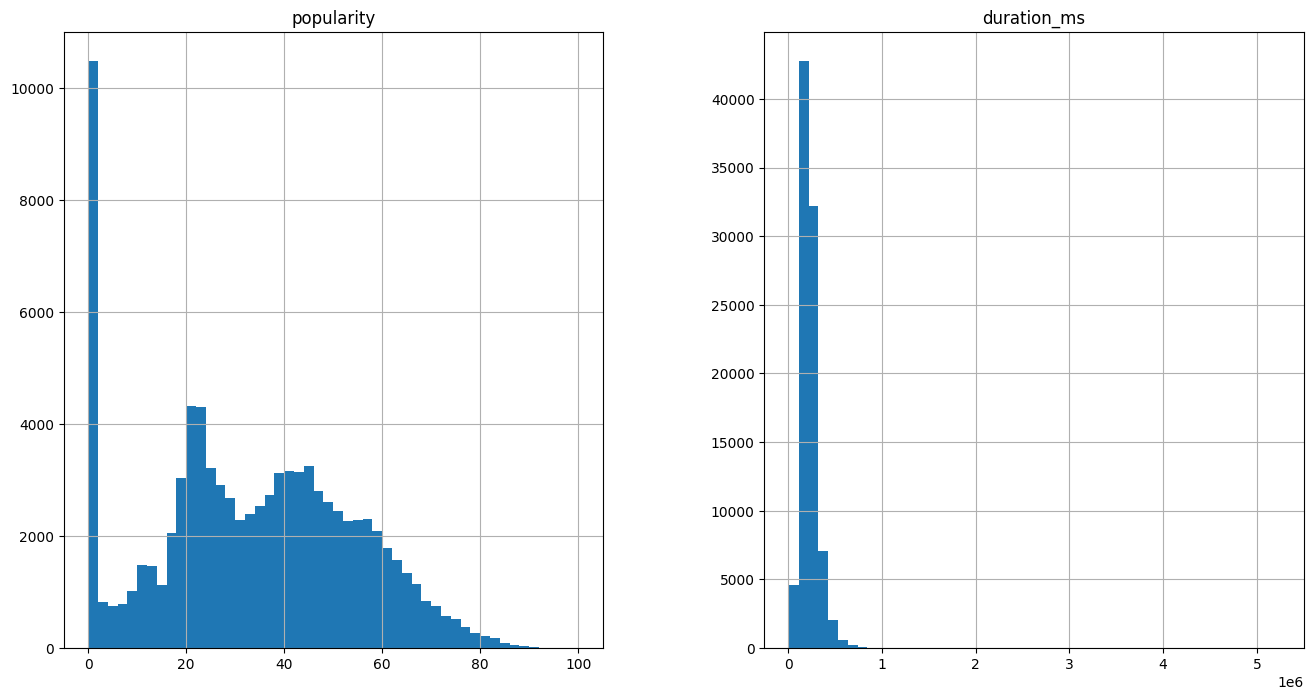

In [84]:
int_cols = ['popularity','duration_ms']
df[int_cols].hist(figsize=(16, 8),bins=50)
plt.show()

#### Binning

In [85]:
# range and stdev as the bin criteria → if data is more dispersed, assign more bins to capture data granularity
three_bin = []
five_bin = []

for x in int_cols:
    range = df[x].max() - df[x].min()
    std = df[x].std()
    if range < 3 * std:
        three_bin.append(x)
    else:
        five_bin.append(x)

print("Columns with 3 bins:", three_bin)
print("Columns with 5 bins:", five_bin)

Columns with 3 bins: []
Columns with 5 bins: ['popularity', 'duration_ms']


In [86]:
labels_3 = ['Low', 'Medium', 'High']
labels_5 = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df_bins = df[['track_id']].copy()

for col in three_bin:
    df_bins[col + '_bin'] = pd.cut(df[col], bins=3, labels=labels_3)

for col in five_bin:
    df_bins[col + '_bin'] = pd.cut(df[col], bins=5, labels=labels_5)

df_bins_int = df_bins
df_bins

,track_id,popularity_bin,duration_ms_bin
0,3nqQXoyQOWXiESFLlDF1hG,Very High,Very Low
1,2tTmW7RDtMQtBk7m2rYeSw,Very High,Very Low
2,5ww2BF9slyYgNOk37BlC4u,Very High,Very Low
3,4uUG5RXrOk84mYEfFvj3cK,Very High,Very Low
4,1IHWl5LamUGEuP4ozKQSXZ,Very High,Very Low
...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,Very Low,Very Low
89736,4WCpgL2vHyx2vusJ5mbBnF,Very Low,Very Low
89737,5FImqqYMK6ZwLwClPDds8c,Very Low,Very Low
89738,4BsasVXlffiJ69bRrJXWZO,Very Low,Very Low


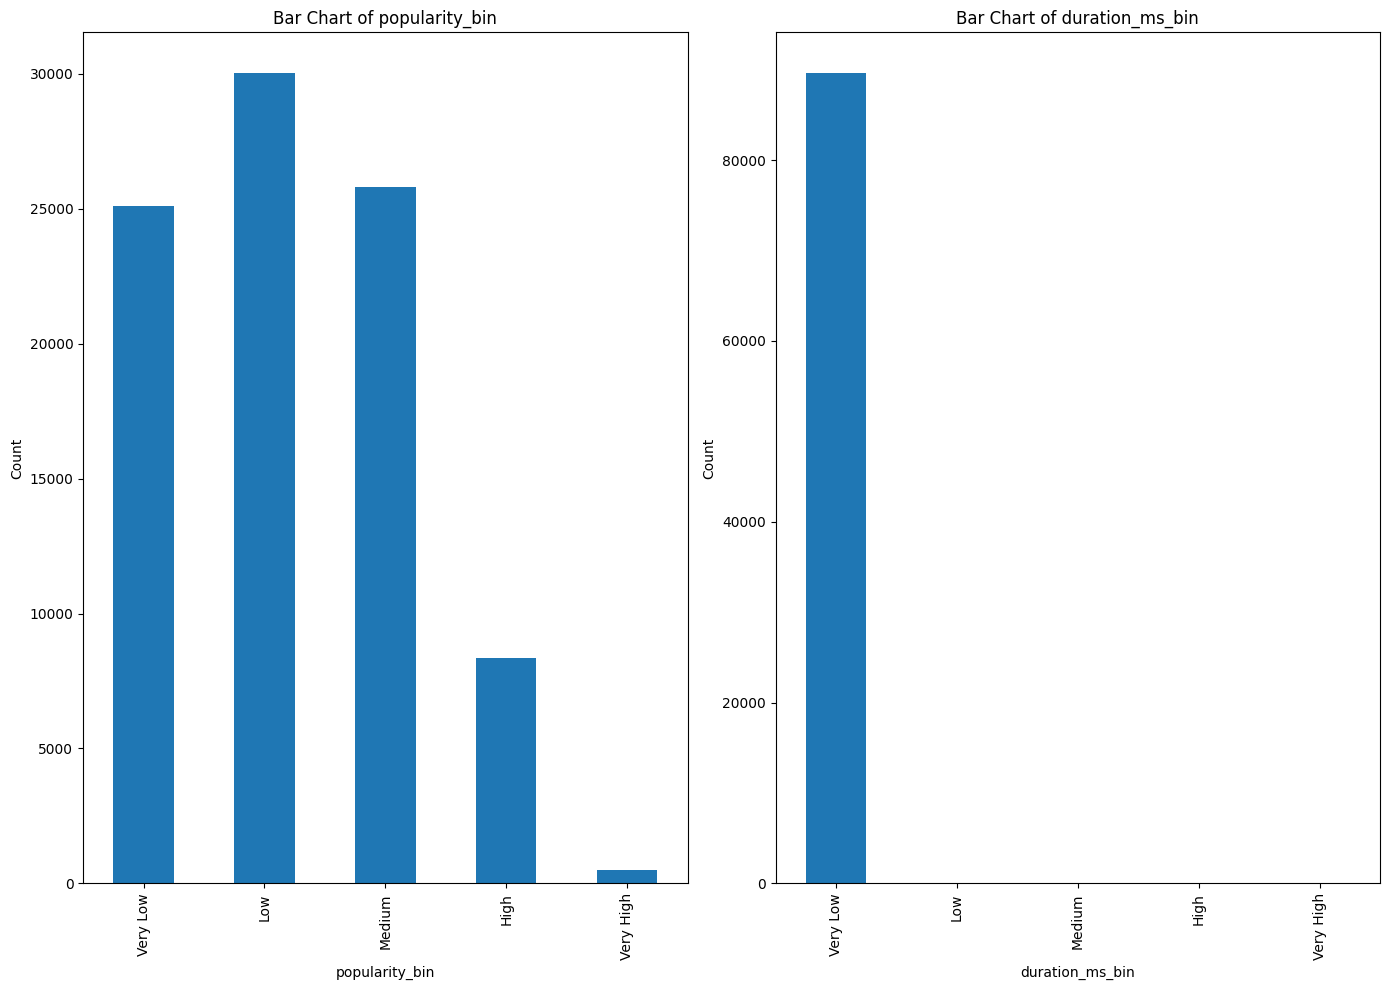

In [35]:
binned_cols = [col for col in df_bins.columns if col.endswith('_bin')]

fig, axes = plt.subplots(1,2,figsize=(14, 10))
axes = axes.flatten()

for i, x in enumerate(binned_cols):
    value_counts = df_bins[x].value_counts().sort_index()
    bars = value_counts.plot(kind='bar', ax=axes[i])

    axes[i].set_title(f"Bar Chart of {x}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel("Count")


plt.tight_layout()
plt.show()

In [36]:
df_int_encoded = pd.get_dummies(df_bins[binned_cols])
df_int_encoded = pd.concat([df_bins[['track_id']], df_int_encoded], axis=1)
df_int_encoded

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,duration_ms_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,False


### Preprocessing Float Columns

In [87]:
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols].describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,0.562166,0.634458,-8.498994,0.087442,0.328285,0.173415,0.216971,0.469474,122.058134
std,0.176692,0.256606,5.221518,0.113278,0.338321,0.323849,0.194885,0.262864,30.117651
min,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.450000,0.457000,-10.322250,0.036000,0.017100,0.000000,0.098200,0.249000,99.262750
50%,0.576000,0.676000,-7.185000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000
75%,0.692000,0.853000,-5.108000,0.085900,0.625000,0.097625,0.279000,0.682000,140.077000
max,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


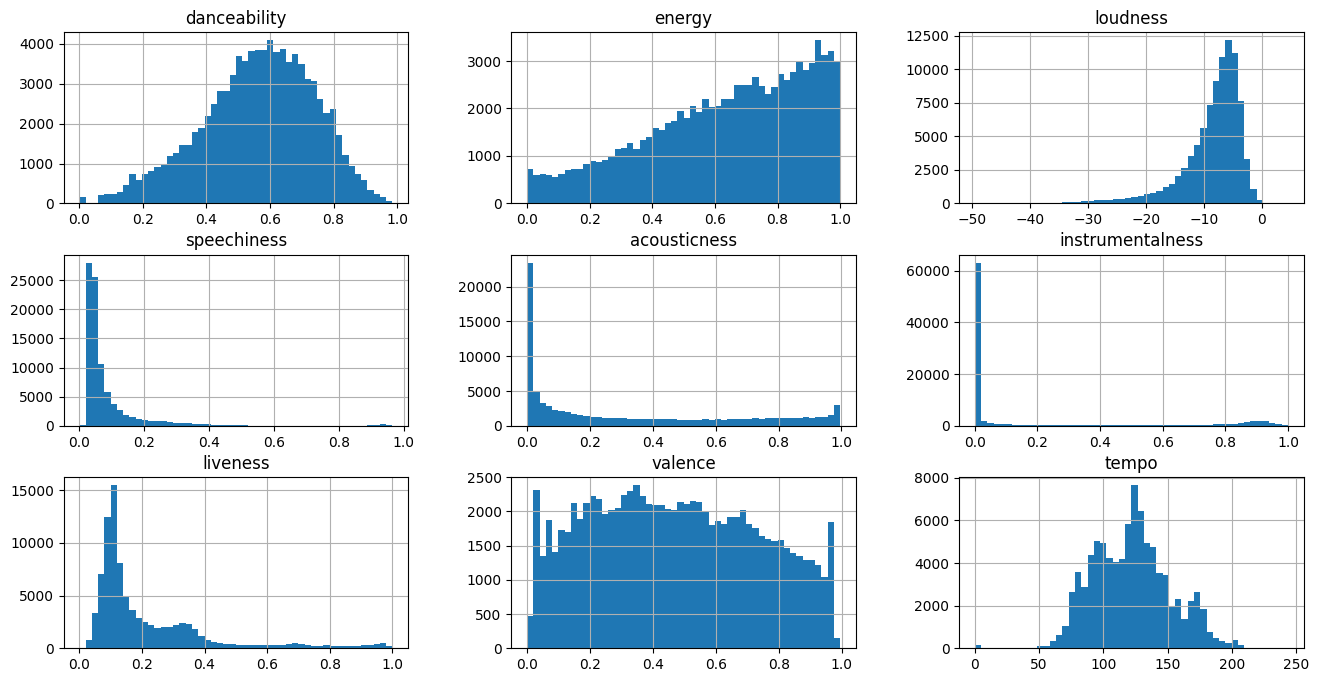

In [88]:
df[float_cols].hist(figsize=(16, 8),bins=50)
plt.show()

#### Binning

In [89]:
# range and stdev as the bin criteria → if data is more dispersed, assign more bins to capture data granularity
three_bins = []
five_bins = []

for x in float_cols:
    range = df[x].max() - df[x].min()
    std = df[x].std()
    if x == 'speechiness':  # based on kaggle column description → 3 bins
        three_bins.append(x)
    elif range < 3 * std:
        three_bins.append(x)
    else:
        five_bins.append(x)

print("Columns with 3 bins:", three_bins)
print("Columns with 5 bins:", five_bins)

Columns with 3 bins: ['speechiness', 'acousticness']
Columns with 5 bins: ['danceability', 'energy', 'loudness', 'instrumentalness', 'liveness', 'valence', 'tempo']


In [90]:
df_bins = df[['track_id']].copy()

for x in three_bins:
    df_bins[x + '_bin'] = pd.cut(df[x], bins=3, labels=labels_3)

for x in five_bins:
    df_bins[x + '_bin'] = pd.cut(df[x], bins=5, labels=labels_5)

df_bins_float = df_bins
df_bins

,track_id,speechiness_bin,acousticness_bin,danceability_bin,energy_bin,loudness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,3nqQXoyQOWXiESFLlDF1hG,Low,Low,High,Medium,High,Very Low,Low,Low,Medium
1,2tTmW7RDtMQtBk7m2rYeSw,Low,Low,High,High,Very High,Very Low,Low,Medium,Medium
2,5ww2BF9slyYgNOk37BlC4u,Low,Medium,Very High,High,Very High,Very Low,Low,Very High,Medium
3,4uUG5RXrOk84mYEfFvj3cK,Low,Low,Medium,Very High,Very High,Very Low,Low,Low,Medium
4,1IHWl5LamUGEuP4ozKQSXZ,Low,Low,High,High,Very High,Very Low,Very Low,Very Low,Medium
...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium
89736,4WCpgL2vHyx2vusJ5mbBnF,Low,Low,High,Very High,Very High,Very Low,Low,Medium,Medium
89737,5FImqqYMK6ZwLwClPDds8c,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium
89738,4BsasVXlffiJ69bRrJXWZO,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium


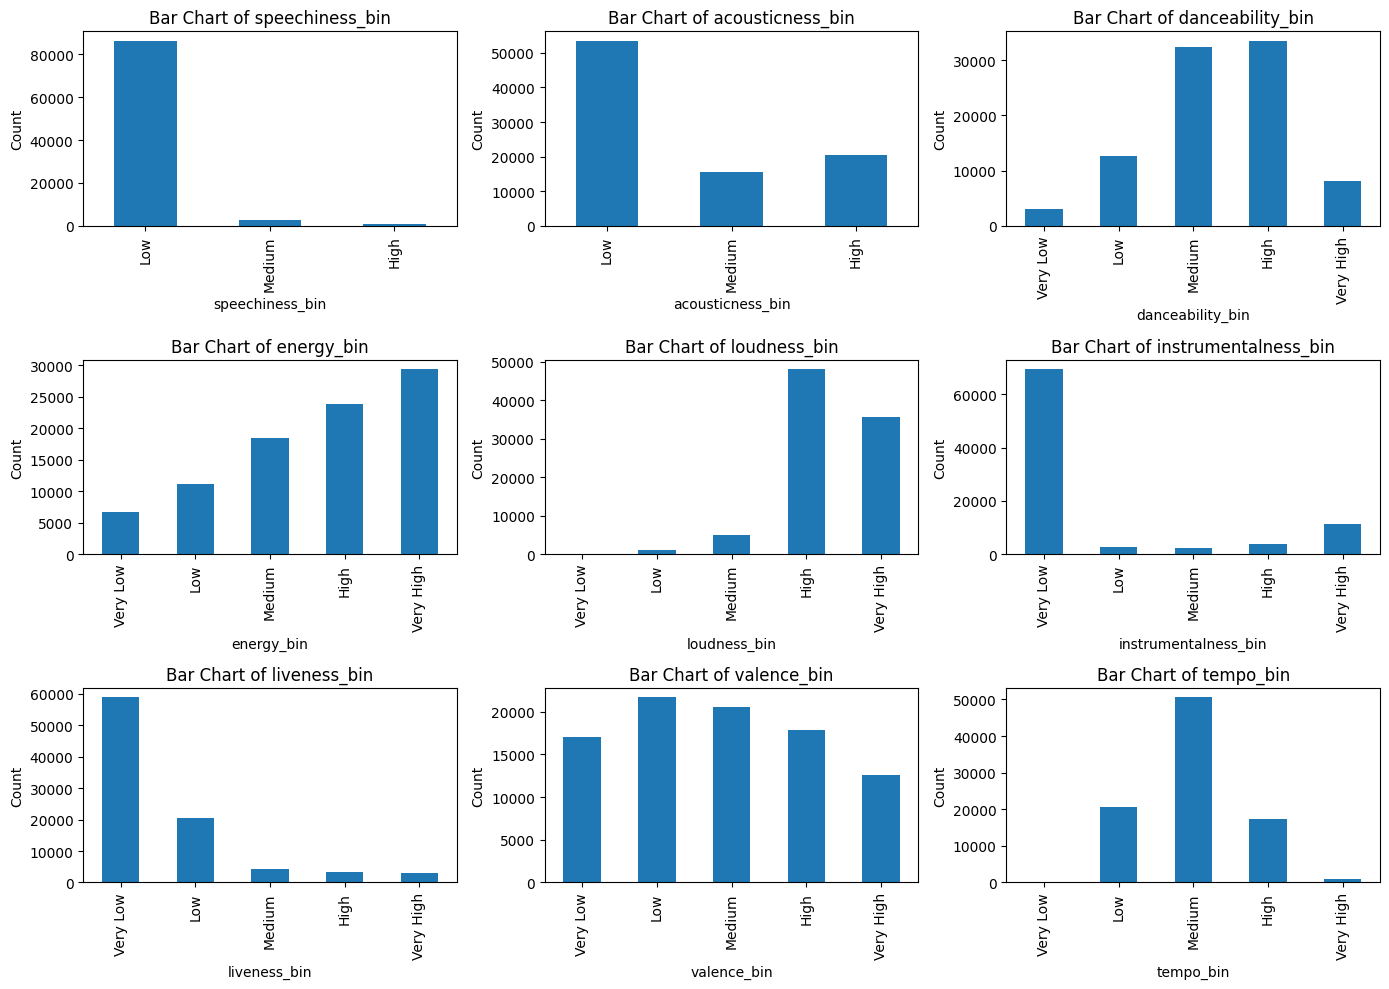

In [41]:
binned_cols = [col for col in df_bins.columns if col.endswith('_bin')]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, x in enumerate(binned_cols):
    value_counts = df_bins[x].value_counts().sort_index()
    bars = value_counts.plot(kind='bar', ax=axes[i])

    axes[i].set_title(f"Bar Chart of {x}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel("Count")


plt.tight_layout()
plt.show()


#### One hot encoding

In [42]:
# one hot encode the features
df_flt_encoded = pd.get_dummies(df_bins[binned_cols])
df_flt_encoded = pd.concat([df_bins[['track_id']], df_flt_encoded], axis=1)
df_flt_encoded

,track_id,speechiness_bin_Low,speechiness_bin_Medium,speechiness_bin_High,acousticness_bin_Low,acousticness_bin_Medium,acousticness_bin_High,danceability_bin_Very Low,danceability_bin_Low,danceability_bin_Medium,...,valence_bin_Very Low,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,True,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,5ww2BF9slyYgNOk37BlC4u,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,4uUG5RXrOk84mYEfFvj3cK,True,False,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,True,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


### Merge

In [43]:
# merge binned int and float vars into one dataframe
df_merged = df_int_encoded.merge(df_flt_encoded, on='track_id', how='inner')
df_merged

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,...,valence_bin_Very Low,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [44]:
# add 'explicit' column
df_merged = df_merged.merge(df[['track_id', 'explicit']], on='track_id', how='left')
df_merged


,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,...,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High,explicit
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [48]:

df_merged2 = df_merged.drop(columns=['track_id'])

transactions = df_merged2.apply(lambda row: list(df_merged2.columns[row.values]), axis=1).tolist()

print(transactions[:5])


[['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Low', 'danceability_bin_High', 'energy_bin_Medium', 'loudness_bin_High', 'instrumentalness_bin_Very Low', 'liveness_bin_Low', 'valence_bin_Low', 'tempo_bin_Medium'], ['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Low', 'danceability_bin_High', 'energy_bin_High', 'loudness_bin_Very High', 'instrumentalness_bin_Very Low', 'liveness_bin_Low', 'valence_bin_Medium', 'tempo_bin_Medium'], ['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Medium', 'danceability_bin_Very High', 'energy_bin_High', 'loudness_bin_Very High', 'instrumentalness_bin_Very Low', 'liveness_bin_Low', 'valence_bin_Very High', 'tempo_bin_Medium'], ['popularity_bin_Very High', 'duration_ms_bin_Very Low', 'speechiness_bin_Low', 'acousticness_bin_Low', 'danceability_bin_Medium', 'energy_bin_Very High', 'loudness_bin_Very High', 'in

## Association Rule Learning

### Frequent Itemset Mining

In [49]:
# calculates the frequent itemset using fpgrowth algorithm
def get_fim(supp, transactions):
    result = fpgrowth(transactions, supp=supp, report='as')
    colnames = ['itemset'] + ['support_absolute', 'support_relative']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

Checking for ideal support threshold

In [50]:
del(range)

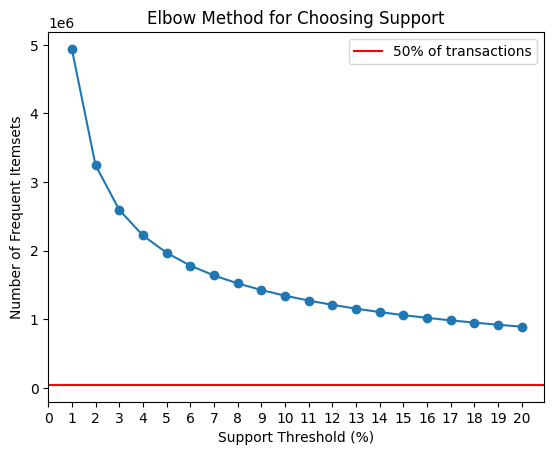

In [51]:
supports = range(1, 21)  # Test supports from 1% to 20%
num_itemsets = []

for supp in supports:
    rules = get_fim(supp*-1, transactions)
    num_itemsets.append(len(rules))

plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_merged)*0.5, color = 'r', label = '50% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

many patterns are very common --> added zmax = to limit itemset size

In [55]:
# calculates the frequent itemset using fpgrowth algorithm
def get_fim(supp, transactions):
    result = fpgrowth(transactions, supp=supp, zmax = 3, report='as')
    colnames = ['itemset'] + ['support_absolute', 'support_relative']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

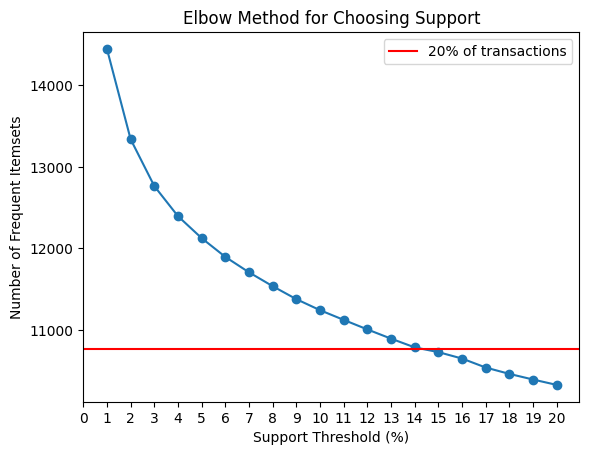

In [61]:
supports = range(1, 21)  # Test supports from 1% to 20%
num_itemsets = []

for supp in supports:
    rules = get_fim(supp*-1, transactions)
    num_itemsets.append(len(rules))

plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_merged)*0.12, color = 'r', label = '20% of transactions')
plt.xticks([x for x in range(21)])
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

### Significant Itemsets

In [65]:
get_fim(-14, transactions)

,itemset,support_absolute,support_relative
0,"(duration_ms_bin_Very Low,)",89646,0.998953
2,"(speechiness_bin_Low,)",86350,0.962224
1,"(speechiness_bin_Low, duration_ms_bin_Very Low)",86262,0.961244
6,"(instrumentalness_bin_Very Low,)",69480,0.774237
3,"(instrumentalness_bin_Very Low, duration_ms_bi...",69433,0.773713
...,...,...,...
7273,"(liveness_bin_Very High, energy_bin_Low, dance...",14,0.000156
8941,"(instrumentalness_bin_Medium, danceability_bin...",14,0.000156
9131,"(loudness_bin_Low, valence_bin_Low, instrument...",14,0.000156
6387,"(liveness_bin_High, energy_bin_Low, valence_bi...",14,0.000156


In [66]:
# calculates the frequent itemset using fpgrowth algorithm
def get_sig(supp, conf, transactions):

    result = arules(transactions, supp=supp, conf=conf, zmax=3, report='asc')
    colnames = ['consequent', 'antecedent'] + ['support_absolute', 'support_relative', 'confidence_pct']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

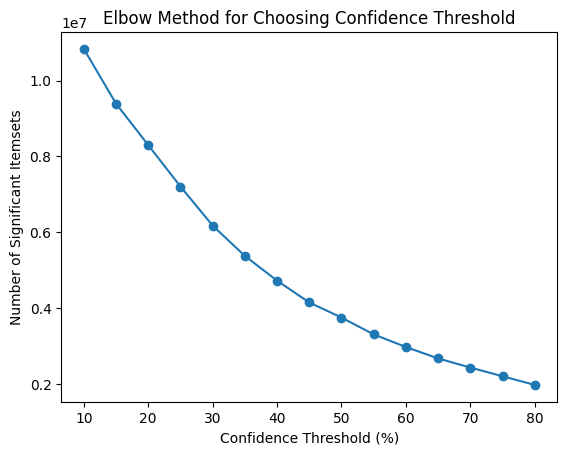

In [67]:
confidence = range(10, 81, 5)  # Test supports from 1% to 20%
num_itemsets = []

for conf in confidence:
    rules = get_sig(-14, conf, transactions)
    num_itemsets.append(len(rules))

plt.plot(confidence, num_itemsets, marker='o')
plt.xlabel("Confidence Threshold (%)")
plt.ylabel("Number of Significant Itemsets")
plt.title("Elbow Method for Choosing Confidence Threshold")
plt.show()

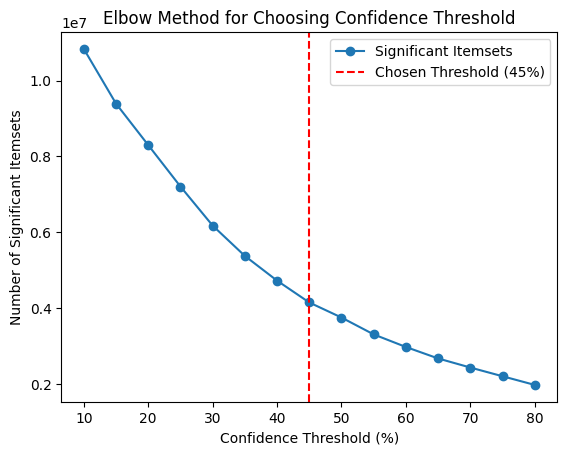

In [68]:
plt.plot(confidence, num_itemsets, marker='o', label="Significant Itemsets")
plt.axvline(x=45, color='r', linestyle='dashed', label="Chosen Threshold (45%)")
plt.xlabel("Confidence Threshold (%)")
plt.ylabel("Number of Significant Itemsets")
plt.title("Elbow Method for Choosing Confidence Threshold")
plt.legend()
plt.show()


In [72]:
# focus on those where popularity appears in the consequent

rules = get_sig(-14, 45, transactions)
rules_filtered = rules[rules["consequent"].astype(str).str.contains("popularity", na=False)]
rules_filtered

,consequent,antecedent,support_absolute,support_relative,confidence_pct
957727,popularity_bin_Very Low,"(instrumentalness_bin_Very High, tempo_bin_Med...",2921,0.032550,0.453853
957670,popularity_bin_Very Low,"(instrumentalness_bin_Very High, tempo_bin_Med...",2913,0.032460,0.453244
957677,popularity_bin_Very Low,"(instrumentalness_bin_Very High, tempo_bin_Med...",2902,0.032338,0.453296
957674,popularity_bin_Very Low,"(instrumentalness_bin_Very High, tempo_bin_Med...",2894,0.032249,0.452683
957667,popularity_bin_Very Low,"(instrumentalness_bin_Very High, acousticness_...",2864,0.031914,0.509156
...,...,...,...,...,...
3099815,popularity_bin_Low,"(liveness_bin_High, loudness_bin_Medium, energ...",7,0.000078,0.500000
3701424,popularity_bin_Very Low,"(instrumentalness_bin_Low, energy_bin_Low, aco...",7,0.000078,0.466667
3701425,popularity_bin_Very Low,"(instrumentalness_bin_Low, energy_bin_Low, aco...",7,0.000078,0.466667
3701426,popularity_bin_Very Low,"(instrumentalness_bin_Low, energy_bin_Low, aco...",7,0.000078,0.466667


In [95]:
def get_antecedents(id, rules_df):

    antecedents_dict = {}

    for id in id:
          antecedents_dict[id] = rules_df.loc[id]["antecedent"]


    return antecedents_dict

id_list = [957727, 957670, 957677, 957674]
antecedents = get_antecedents(id_list, rules_filtered)

for id, antecedent in antecedents.items():
    print(f"Index {id}: {antecedent}")


Index 957727: ('instrumentalness_bin_Very High', 'tempo_bin_Medium')
Index 957670: ('instrumentalness_bin_Very High', 'tempo_bin_Medium', 'duration_ms_bin_Very Low')
Index 957677: ('instrumentalness_bin_Very High', 'tempo_bin_Medium', 'speechiness_bin_Low')
Index 957674: ('instrumentalness_bin_Very High', 'tempo_bin_Medium', 'speechiness_bin_Low', 'duration_ms_bin_Very Low')


observations:

among the top 4 rules, among which all had a consequent of very low popularity, very high instrumentalness and medium tempo appeared as an antecedent for all

additional items that appeared was very low duration and low speechiness

In [98]:
df_combined = pd.merge(df_bins_int[['track_id', 'popularity_bin']], df_bins_float[['track_id', 'tempo_bin', 'instrumentalness_bin']], on='track_id', how='inner')

df_combined = pd.merge(df_combined, df[['track_id','track_genre']], on='track_id', how='inner')

df_check = df_combined[(df_combined["instrumentalness_bin"] == 'Very High') & (df_combined["tempo_bin"] == 'Medium')]
print(df_check["popularity_bin"].value_counts())


popularity_bin
Very Low     2921
Medium       1704
Low          1646
High          163
Very High       2
Name: count, dtype: int64


In [104]:
df_check = df_combined[(df_combined["instrumentalness_bin"] == 'Very High') & (df_combined["tempo_bin"] == 'Medium') & (df_combined["popularity_bin"] == 'Very Low')]
print(df_check["track_genre"].value_counts().head(5))


track_genre
piano                23
ambient              17
sleep                11
chill                10
progressive-house     9
Name: count, dtype: int64


In [106]:
df_check = df_combined[(df_combined["instrumentalness_bin"] == 'Very High') & (df_combined["tempo_bin"] == 'Medium') & ((df_combined["popularity_bin"] == 'High') | (df_combined["popularity_bin"] == 'Very High'))]
print(df_check["track_genre"].value_counts().head(5))

track_genre
piano                23
ambient              17
sleep                11
chill                10
progressive-house     9
Name: count, dtype: int64


**Spotify Dataset** (Total of 55 pts.)

1. Find another dataset that can be turned into an association rule learning problem. Ideally, more than 1000 transactions/records. This does not have to be grocery-related. (20 pts)
2. Similar to the grocery dataset, calculate the association rules and find the `significant/interesting` items. (10 pts)

3. What would you recommend given the association rules? (20 pts)
  - Based on our analysis, songs that have very high instrumentalness and medium tempo often have lower popularity. This does not mean, however, that these songs cannot get popular. There are songs containing these characteristics that have a very high popularity status. These characteristics may be more common in niche genres that dont often reach the same mainstream success as other songs. Looking at the genres of songs with very high instrumentalness, medium tempo, and very low popularity, most fall under the general category of underground EDM music, extreme metal/punk, and regional music. At the point of view of someone in the music industry, analysis of audience expectations and music trends may help influence the way music is produced whether the goal is for an artist to reach mainstream or reach stronger engagement with more niche audiences.


4. Any other learnings? (5 pts)
  - A lot of preprocessing may be needed depending on the original set of data to transform it into a form that can be used for association rule learning.
  - The context in which association rule learning is used is very important. Unlike the groceries dataset wherein the goal was more clearly defined, the spotify dataset, having a lot of features, was more open ended. It might not have been needed to include everything in the association rule learning section as it would depend on the goal of the analysis. Using only the relevant features to the research goal may also improve the effectiveness of association rule learning.
  - Correlation does not imply causality. Just like in the spotify dataset, it doesn't mean that very high instrumentalness and medium tempo in a song causes very low popularity. Extra analysis on the results may be done to extract useful insights

## Writeup/Analysis

Refer to the **Requirements section** for the guide questions.

## References

- sir jude
-

## End
<sup>made by **Jude Michael Teves**</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> <href>judemichaelteves@gmail.com</href> or <href>jude.teves@dlsu.edu.ph</href></sup><br>